In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os

def read_healpix_map(CMB_map_path, frequency, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    if frequency == "545":
        original_healpix_map = original_healpix_map/58.0356
    if frequency == "857":
        original_healpix_map = original_healpix_map/2.2681
    # if plot:
    #     hp.mollview(
    #         original_healpix_map * 1e6,
    #         coord=["G"],
    #         title="Full Sky CMB",
    #         unit=r"$μ$K",
    #         min=-300,
    #         max=300,
    #     )
    #     plt.show()
        if plot:
            hp.mollview(
                original_healpix_map,
                coord=["G"],
                title="Full Sky CMB",
                unit=r"$μ$K",
                # min=-300,
                # max=300,
            )
            plt.show()
    return original_healpix_map

def hp_map_2_hp_alm(healpix_map, L_max):
    hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)
    return hp_alm

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm
def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm
def visualize_wavelet_coefficient_map(MW_Pix_Map,title, Frequency, min=None, max=None):
    """
    Processes a wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        original_70: numpy array representing the wavelet coefficient map.

    Returns:
        Displays a mollview map.
    """

    if MW_Pix_Map.shape[0] != 1:
        L_max = MW_Pix_Map.shape[0]
    else:
        L_max = MW_Pix_Map.shape[1]
    original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
    print("Original map alm shape:", original_map_alm.shape)
    
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        # original_hp_map * 1e5,
        original_hp_map,
        coord=["G"],
        title=title+Frequency,
        # unit=r"$1e5$K",
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )

def wavelet_transform(mw_map, L_max, N_directions):
    filter = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs = s2wav.analysis(mw_map, N=N_directions, L=L_max, filters=filter, reality=False)
    return MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs

def save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization):
    for i, wav in enumerate(wavelet_coeffs):
        np_wav = np.array(wav)  # Convert JAX array to numpy array
        np.save(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{i}_R{realization:04d}", np_wav)

    np_scal = np.array(scaling_coeffs)
    np.save(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}_R{realization:04d}", np_scal)

def load_wavelet_scaling_coeffs(frequency, num_wavelets, realization):
    wavelet_coeffs = [np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{i}_R{realization:04d}.npy")) for i in range(num_wavelets)]
    scaling_coeffs = np.real(np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}_R{realization:04d}.npy"))
    return wavelet_coeffs, scaling_coeffs

def generate_wavelets(CMB_map_path, frequency, L_max, N_directions, realization):
    # Step 1: Read the Healpix map
    healpix_map = read_healpix_map(CMB_map_path,frequency)

    # Step 2: Convert Healpix map to spherical harmonic coefficients
    hp_alm = hp_map_2_hp_alm(healpix_map, L_max)

    # Step 3: Convert spherical harmonics to MW coefficients
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)

    # Step 4: Transform MW coefficients back to a map (optional, based on use case)
    original_MW_Map = s2fft.inverse(mw_alm, L_max)
    np.save(f'wavelet_transform/maps/Original_MW_Pix_map_F{frequency}_R{realization:04d}.npy', original_MW_Map)

    # Step 5: Apply wavelet transform to the MW map to get wavelet and scaling coefficients
    wavelet_coeffs, scaling_coeffs = wavelet_transform(original_MW_Map, L_max, N_directions)

    # Step 6: Save the wavelet and scaling coefficients
    save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization)

    # Step 7: Load the wavelet and scaling coefficients
    loaded_wavelet_coeffs, loaded_scaling_coeffs = load_wavelet_scaling_coeffs(frequency, len(wavelet_coeffs), realization)

    # Print shapes for verification
    for i in range(len(loaded_wavelet_coeffs)):
        print("wavelets shape", loaded_wavelet_coeffs[i].shape)
        # visualize_wavelet_coefficient_map(loaded_wavelet_coeffs[i], f"Wavelet {i}", frequency)
    return loaded_wavelet_coeffs, loaded_scaling_coeffs, original_MW_Map




# if __name__ == "__main__":
#     frequency = "030"
#     L_max = 16
#     N_directions = 1
#     realization = 0  # Example realization number
#     CMB_map_path = f'../data/planck_simulation/ffp10_newdust_total_{frequency}_full_map.fits'

#     generate(CMB_map_path, frequency, L_max, N_directions, realization)


In [2]:
def process_cmb_data(L_max, N_directions, realization_list, frequencies, data_path_template):
    """
    Process CMB data and generate wavelets for each frequency and realization.

    Parameters:
    L_max (int): The maximum multipole moment.
    N_directions (int): The number of directions for the wavelets.
    realization_list (list): A list of realizations to process.
    frequencies (list): A list of frequency strings.
    data_path_template (str): Template for the data path with a placeholder for frequency.
    generate_wavelets (function): Function to generate wavelets, taking parameters CMB_map_path, frequency, L_max, N_directions, realization.
    """
    
       
    for realization in realization_list:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization}")
        for frequency in frequencies:
            print(f"Processing frequency {frequency}")
            CMB_map_path = data_path_template.format(frequency=frequency, L_max = L_max, realization=realization_str)
            if not os.path.exists(CMB_map_path): 
                print(f"File {CMB_map_path} does not exist")
                continue 
            wavelet_path = f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S5_R{realization_str}.npy"
            if os.path.exists(wavelet_path): 
                print(f"File {wavelet_path} already exist")
                continue 
            wavelet, scal, original = generate_wavelets(CMB_map_path, frequency, L_max, N_directions, realization)
    return wavelet, scal, original
        # You can add any additional processing or saving logic here if needed

# Example usage
L_max = 32
N_directions = 1
realization_list = range(10)
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
# data_path_template = 'CMB_total/CSN_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'
data_path_template = 'CMB_total/CMB_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'

wavelet, scal, original = process_cmb_data(L_max, N_directions, realization_list, frequencies, data_path_template)



Processing realization 0
Processing frequency 030
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F030_S5_R0000.npy already exist
Processing frequency 044
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F044_S5_R0000.npy already exist
Processing frequency 070
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F070_S5_R0000.npy already exist
Processing frequency 100
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F100_S5_R0000.npy already exist
Processing frequency 143
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F143_S5_R0000.npy already exist
Processing frequency 217
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F217_S5_R0000.npy already exist
Processing frequency 353
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F353_S5_R0000.npy already exist
Processing frequency 545
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F545_S5_R0000.npy already exist
Processing frequency 857
File wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


wavelets shape (1, 4, 7)
wavelets shape (1, 4, 7)
wavelets shape (1, 8, 15)
wavelets shape (1, 16, 31)
wavelets shape (1, 32, 63)
wavelets shape (1, 32, 63)
Processing frequency 044
wavelets shape (1, 4, 7)
wavelets shape (1, 4, 7)
wavelets shape (1, 8, 15)
wavelets shape (1, 16, 31)
wavelets shape (1, 32, 63)
wavelets shape (1, 32, 63)
Processing frequency 070
wavelets shape (1, 4, 7)
wavelets shape (1, 4, 7)
wavelets shape (1, 8, 15)
wavelets shape (1, 16, 31)
wavelets shape (1, 32, 63)
wavelets shape (1, 32, 63)
Processing frequency 100
wavelets shape (1, 4, 7)
wavelets shape (1, 4, 7)
wavelets shape (1, 8, 15)
wavelets shape (1, 16, 31)
wavelets shape (1, 32, 63)
wavelets shape (1, 32, 63)
Processing frequency 143
wavelets shape (1, 4, 7)
wavelets shape (1, 4, 7)
wavelets shape (1, 8, 15)
wavelets shape (1, 16, 31)
wavelets shape (1, 32, 63)
wavelets shape (1, 32, 63)
Processing frequency 217
wavelets shape (1, 4, 7)
wavelets shape (1, 4, 7)
wavelets shape (1, 8, 15)
wavelets shape

(32, 63)
Original map alm shape: (32, 63)


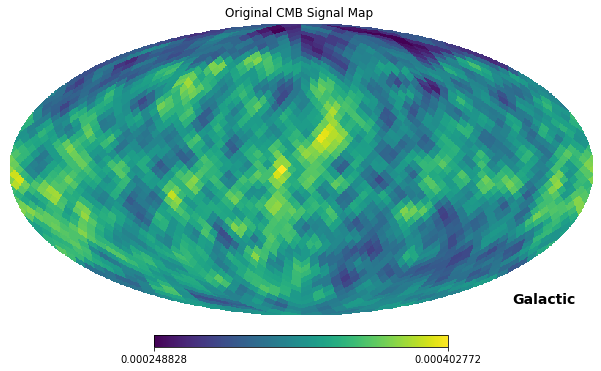

In [44]:
from s2wav import filters
L_max = 32
N_directions = 1
filter = filters.filters_directional_vectorised(L_max, N_directions)
# f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 

# [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

MW_Pix = s2wav.synthesis(wavelet, L = L_max, f_scal = f_scal, filters = filter, N = 1)
print(MW_Pix.shape)
title = "Original CMB Signal Map "
visualize_wavelet_coefficient_map(MW_Pix, title, "")

In [38]:
# cmb = hp.read_map("/home/max/CMB_plot/code/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits",)

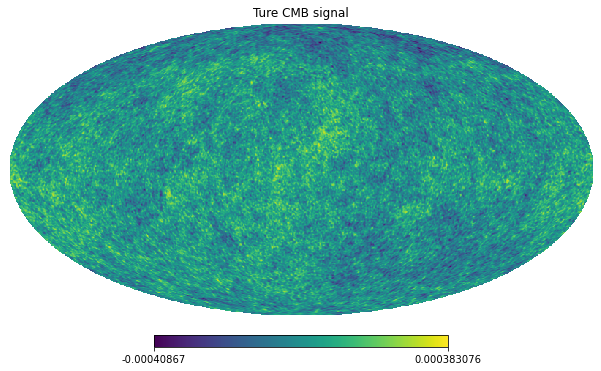

In [34]:
cmb.shape

hp.mollview(cmb, title="Ture CMB signal")    

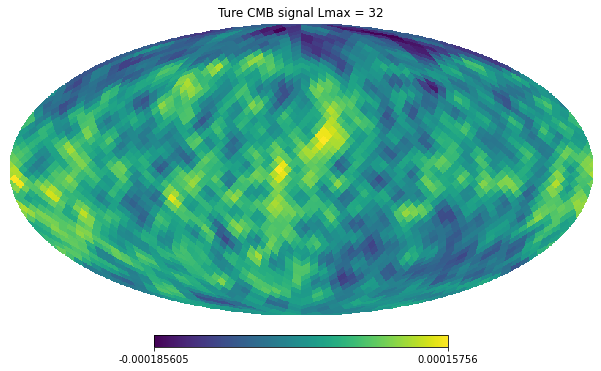

In [42]:
new_map = hp.alm2map(hp.map2alm(cmb, lmax=32),nside=32//2)
hp.mollview(new_map, title="Ture CMB signal Lmax = 32")

In [44]:
MW_Pix_1 = s2wav.synthesis(wavelet, np.array(([[0]])), L=32, filters=filters.filters_directional_vectorised(32, 1), reality=False)

In [46]:
MW_Pix = s2wav.synthesis(wavelet, scal, L=32, filters=filters.filters_directional_vectorised(32, 1), reality=False)

In [37]:
scal

array([[4.77683253]])

In [45]:
MW_Pix_1

Array([[-10.4890746 +4.28774535e-16j, -10.43530725+7.38425216e-16j,
        -10.37582987+9.27077241e-16j, ..., -10.60930959-5.77966736e-16j,
        -10.5779276 -2.34612791e-17j, -10.53704677-7.03408473e-17j],
       [  0.38548789-3.64285164e-16j,   0.42151049-7.41587520e-16j,
          0.44017302-8.40466758e-16j, ...,   0.32921558+9.44369710e-16j,
          0.34677333+3.94138180e-16j,   0.35925261+1.51138445e-16j],
       [ -8.82226449-4.50987409e-16j,  -8.51159709-1.80370545e-16j,
         -7.98879596+4.71885480e-16j, ...,  -7.73514873-8.79178362e-16j,
         -8.35930693-1.13658425e-15j,  -8.77324494-9.34386562e-16j],
       ...,
       [ -5.48477849-8.67983814e-16j,  -5.47400073-2.42616001e-16j,
         -5.37898647+2.24891976e-16j, ...,  -5.18808589-2.39348078e-15j,
         -5.30349714-1.93184534e-15j,  -5.41738108-1.43096254e-15j],
       [ -2.34465509-4.05765172e-16j,  -2.52447514-2.17547675e-16j,
         -2.77346997-2.03453047e-16j, ...,  -2.31772903-1.05864427e-15j,
       

In [48]:
MW_Pix

Array([[-5.71224207+4.28774535e-16j, -5.65847472+7.38425216e-16j,
        -5.59899734+9.27077241e-16j, ..., -5.83247706-5.77966736e-16j,
        -5.80109507-2.34612791e-17j, -5.76021423-7.03408473e-17j],
       [ 5.16232042-3.64285164e-16j,  5.19834302-7.41587520e-16j,
         5.21700556-8.40466758e-16j, ...,  5.10604811+9.44369710e-16j,
         5.12360587+3.94138180e-16j,  5.13608514+1.51138445e-16j],
       [-4.04543195-4.50987409e-16j, -3.73476456-1.80370545e-16j,
        -3.21196342+4.71885480e-16j, ..., -2.9583162 -8.79178362e-16j,
        -3.5824744 -1.13658425e-15j, -3.9964124 -9.34386562e-16j],
       ...,
       [-0.70794595-8.67983814e-16j, -0.6971682 -2.42616001e-16j,
        -0.60215394+2.24891976e-16j, ..., -0.41125336-2.39348078e-15j,
        -0.5266646 -1.93184534e-15j, -0.64054855-1.43096254e-15j],
       [ 2.43217744-4.05765172e-16j,  2.25235739-2.17547675e-16j,
         2.00336256-2.03453047e-16j, ...,  2.4591035 -1.05864427e-15j,
         2.53971916-7.57742742e-16j

In [47]:
MW_Pix/MW_Pix_1

Array([[ 0.54458971-1.86163550e-17j,  0.54224323-3.23918724e-17j,
         0.53961923-4.11348816e-17j, ...,  0.54975086+2.45283658e-17j,
         0.54841509+1.00159125e-18j,  0.54666306+3.02628480e-18j],
       [13.39165391+1.17100842e-14j, 12.33265403+1.99381867e-14j,
        11.8521701 +2.07211431e-14j, ..., 15.50974011-4.16218424e-14j,
        14.77508609-1.56565884e-14j, 14.29658418-5.59390530e-15j],
       [ 0.45854802+2.76786106e-17j,  0.4387854 +1.18927837e-17j,
         0.40205851-3.53194533e-17j, ...,  0.38245111+7.01907155e-17j,
         0.42856117+7.76964375e-17j,  0.45552272+5.79890629e-17j],
       ...,
       [ 0.12907467+1.37826732e-16j,  0.1273599 +3.86767304e-17j,
         0.11194561-3.71289846e-17j, ...,  0.0792688 +4.24771769e-16j,
         0.09930515+3.28085996e-16j,  0.11823952+2.32910736e-16j],
       [-1.03732846+3.52579335e-16j, -0.89220819+1.63061812e-16j,
        -0.72233072+1.26344772e-16j, ..., -1.06099698+9.41379519e-16j,
        -1.13526618+7.23245620e-16j